In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os
train_file_path = "/content/drive/My Drive/StockData/final_validtest_set.csv"
test_file_path = "/content/drive/My Drive/StockData/final_test_set.csv"

if os.path.exists(test_file_path):
    test_df = pd.read_csv(test_file_path)
    print("Data loaded from CSV.")
if os.path.exists(train_file_path)    :
    train_df = pd.read_csv(train_file_path)
    print("Data loaded from CSV.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded from CSV.
Data loaded from CSV.


In [ ]:
cont_vars = ['Open', 'High', 'Low', 'Close', 'Adj Close','Volume', 'rsi','stochastic','signal-stochastic','cci', 'williams%R','roc','awesome-oscillator','ultimate-oscillator','trix','KAMA','stochrsi','sma','macd','ema','adx','psar-up','psar-down', 'ichimoku_a','ichimoku_b','supertrend','KST','plus_di','minus_di','VI-dff','VI+','VI-','atr','bb_bbm',
              'donchianwidth','keltnerwidth','ulcer','chaikin_volatility','historical_volatility','upper_band','lower_band'] # Remove 'Ticker' from cont_vars
seq_length = 20
forecast_horizon = 14
target_col = 'return_14d'
ticker_col = 'Ticker'
date_col = 'Date'
batch_size = 64

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import joblib
from matplotlib.ticker import FuncFormatter # Import FuncFormatter
import yfinance as yf
import ta

def prepare_test_sequences(
    df,
    seq_length,
    forecast_horizon,
    cont_vars,
    target_col,
    ticker_col,
    date_col
):

    if not np.issubdtype(df[date_col].dtype, np.datetime64):
        df[date_col] = pd.to_datetime(df[date_col])

    df_sorted = df.sort_values([ticker_col, date_col]).reset_index()

    X_test = []
    y_test = []
    original_indices = []
    target_info_list = []

    tickers = df_sorted[ticker_col].unique()

    print(f"Preparing sequences for {len(tickers)} tickers...")

    for ticker in tickers:
        group = df_sorted[df_sorted[ticker_col] == ticker].reset_index(drop=True)

        n_rows = len(group)
        min_rows_needed = seq_length + forecast_horizon
        if n_rows < min_rows_needed:
            print(f"Ticker '{ticker}' skipped: not enough rows ({n_rows} < {min_rows_needed})")
            continue

        required_cols = cont_vars + [target_col, 'index']
        missing_cols = [col for col in required_cols if col not in group.columns]
        if missing_cols:
            print(f"Ticker '{ticker}' skipped: missing columns {missing_cols}")
            continue

        group = group.replace([np.inf, -np.inf], np.nan)


        features = group[cont_vars].to_numpy(dtype=np.float32)
        targets = group[target_col].to_numpy(dtype=np.float32)
        dates_arr = group[date_col].to_numpy()
        original_indices_arr = group['index'].to_numpy()

        max_start_idx = n_rows - seq_length - forecast_horizon + 1

        valid_seq_count = 0
        skipped_nan_target = 0
        skipped_nan_features = 0

        for start_idx in range(max_start_idx):
            seq_end_idx = start_idx + seq_length
            target_idx = seq_end_idx + forecast_horizon - 1

            if np.isnan(targets[target_idx]):
                skipped_nan_target += 1
                continue

            seq = features[start_idx:seq_end_idx].flatten()

            if np.isnan(seq).any():
                skipped_nan_features += 1
                continue

            X_test.append(seq)
            y_test.append(targets[target_idx])
            original_indices.append(original_indices_arr[target_idx])

            target_info_list.append({'Date': dates_arr[target_idx], 'Ticker': ticker, target_col: targets[target_idx]})

            valid_seq_count += 1

        print(
            f"Ticker '{ticker}': Generated {valid_seq_count} valid sequences, "
            f"skipped {skipped_nan_target} due to NaN targets, "
            f"skipped {skipped_nan_features} due to NaN features."
        )

    if len(X_test) == 0:
        print("Warning: No valid sequences generated in test set.")
        return np.array([]), np.array([]), pd.DataFrame(columns=['Date', 'Ticker', target_col]), np.array([])

    X_test = np.array(X_test)
    y_test = np.array(y_test, dtype=np.float32)
    original_indices = np.array(original_indices)
    target_info_df = pd.DataFrame(target_info_list)
    target_info_df['Date'] = pd.to_datetime(target_info_df['Date'])


    print(f"Total test sequences generated: {len(X_test)}")
    return X_test, y_test, target_info_df, original_indices

In [ ]:
cols_with_nans = ['psar-up', 'psar-down', 'KST']
for col in cols_with_nans:
    test_df[col] = test_df[col].fillna(method='ffill').fillna(0)
print(test_df[cont_vars].isna().sum())

Open                     0
High                     0
Low                      0
Close                    0
Adj Close                0
Volume                   0
rsi                      0
stochastic               0
signal-stochastic        0
cci                      0
williams%R               0
roc                      0
awesome-oscillator       0
ultimate-oscillator      0
trix                     0
KAMA                     0
stochrsi                 0
sma                      0
macd                     0
ema                      0
adx                      0
psar-up                  0
psar-down                0
ichimoku_a               0
ichimoku_b               0
supertrend               0
KST                      0
plus_di                  0
minus_di                 0
VI-dff                   0
VI+                      0
VI-                      0
atr                      0
bb_bbm                   0
donchianwidth            0
keltnerwidth             0
ulcer                    0
c

<ipython-input-38-fc980ef4cc6d>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df[col] = test_df[col].fillna(method='ffill').fillna(0)


Model loaded successfully from /content/drive/MyDrive/StockModels/xgb_best_model_randomsearch.joblib
Preparing sequences for 498 tickers...
Ticker 'A': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'AAPL': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'ABBV': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'ABNB': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'ABT': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'ACGL': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'ACN': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
Ticker 'ADBE': Generated 100 valid sequences, skipped 14 due to NaN targets, skipped 0 due to NaN features.
T

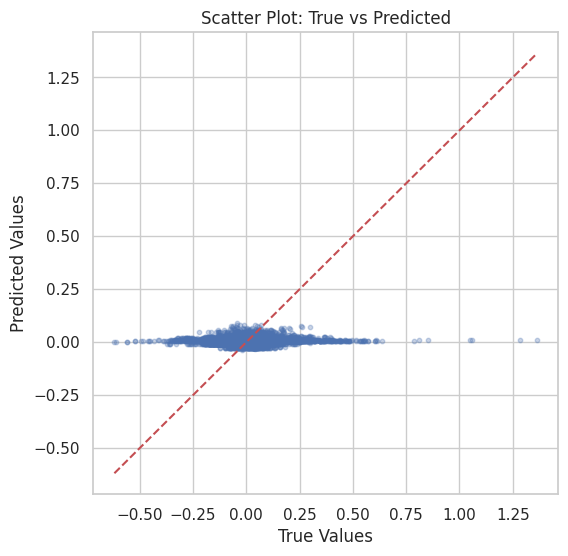

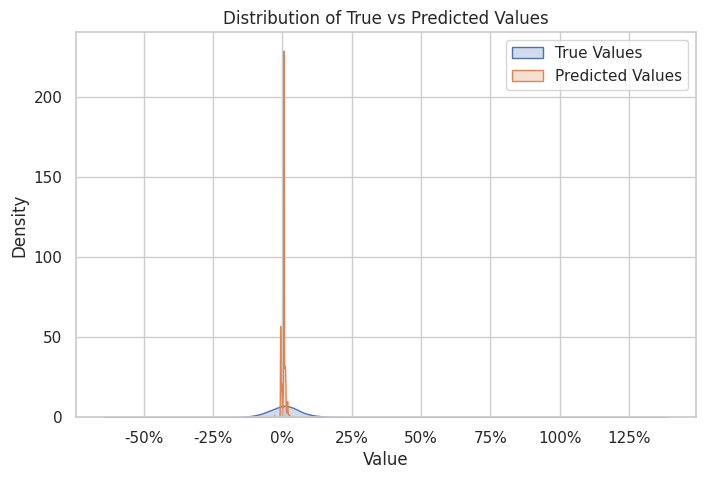

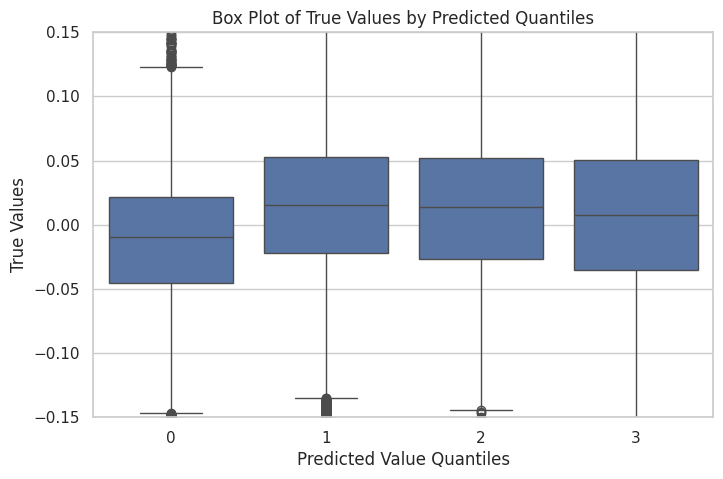

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
from matplotlib.ticker import FuncFormatter

model_path = '/content/drive/MyDrive/StockModels/xgb_best_model_randomsearch.joblib'
try:
    best_model = joblib.load(model_path)
    print(f"Model loaded successfully from {model_path}")
except Exception as e:
    print(f"Error loading model from {model_path}: {e}")
    best_model = None


if 'best_model' not in globals() or best_model is None:
    print("Error: XGBoost model ('best_model') not found or not trained. Please run the previous cells successfully.")
else:

    X_test, y_test, target_info_df,original_indices = prepare_test_sequences(
        test_df,
        seq_length=10,
        forecast_horizon=14,
        cont_vars=cont_vars,
        target_col=target_col,
        ticker_col=ticker_col,
        date_col=date_col,
    )

    print(f"Test data shape: {X_test.shape}, Test targets shape: {y_test.shape}")
    print(f"Target Info shape: {target_info_df.shape}")

    if len(X_test) == 0 or len(y_test) == 0 or target_info_df.empty:
        print("No test data sequences were generated. Cannot proceed with prediction and evaluation.")
    else:
        y_test_pred = best_model.predict(X_test)

        mae_test = mean_absolute_error(y_test, y_test_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        print(f"Test MAE: {mae_test:.4f}")
        print(f"Test MSE: {mse_test:.4f}")

        plot_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_test_pred})

        if 'clip_min' in globals() and 'clip_max' in globals():
             plot_df['y_true_clipped'] = plot_df['y_true'].clip(clip_min, clip_max)
             plot_df['y_pred_clipped'] = plot_df['y_pred'].clip(clip_min, clip_max)
             print("Clipped y_true and y_pred for plotting.")
             plot_y_true = plot_df['y_true_clipped']
             plot_y_pred = plot_df['y_pred_clipped']
        else:
             print("clip_min and clip_max not found. Plotting unclipped values.")
             plot_y_true = plot_df['y_true']
             plot_y_pred = plot_df['y_pred']



        plt.figure(figsize=(6,6))
        plt.scatter(plot_y_true, plot_y_pred, alpha=0.3, s=10)
        min_val = min(plot_y_true.min(), plot_y_pred.min())
        max_val = max(plot_y_true.max(), plot_y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title("Scatter Plot: True vs Predicted")
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(8,5))
        sns.kdeplot(plot_y_true, label='True Values', fill=True)
        sns.kdeplot(plot_y_pred, label='Predicted Values', fill=True)
        plt.title('Distribution of True vs Predicted Values')
        plt.xlabel('Value')
        plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
        plt.legend()
        plt.show()

        if len(np.unique(plot_df['y_pred'])) >= 5:
            try:
                quantiles = pd.qcut(plot_df['y_pred'], q=5, labels=False, duplicates='drop')
                boxplot_df = pd.DataFrame({'True': plot_y_true, 'PredictedQuantile': quantiles})

                plt.figure(figsize=(8,5))
                sns.boxplot(x='PredictedQuantile', y='True', data=boxplot_df)
                plt.xlabel("Predicted Value Quantiles")
                plt.ylabel("True Values")
                plt.title("Box Plot of True Values by Predicted Quantiles")
                plt.ylim(-0.15,0.15)
                plt.show()
            except Exception as e:
                 print(f"Error creating or plotting box plot by quantiles: {e}")
        else:
            print(f"Not enough unique predicted values ({len(np.unique(plot_df['y_pred'] ))}) to create 5 quantiles for box plot.")

In [ ]:
if len(original_indices) > 0:
    original_indices = original_indices.astype(int)

    if 'test_df' in locals():
        if not pd.Index(original_indices).isin(test_df.index).all():
            print("Warning: Some original indices are not present in the original test_df.")
            valid_indices_mask = pd.Index(original_indices).isin(test_df.index)
            original_indices = original_indices[valid_indices_mask]
            preds = preds[valid_indices_mask]
            targs = targs[valid_indices_mask]
            print(f"Filtered down to {len(original_indices)} valid indices.")

        eval_df_source = test_df.loc[original_indices].reset_index(drop=True)

        if len(targs) == len(preds) == len(eval_df_source):
            eval_df = pd.DataFrame({
                'Date': eval_df_source['Date'].values,
                'Ticker': eval_df_source['Ticker'].values,
                'Close': eval_df_source['Close'].values,
                'y_true': targs,
                'y_pred': preds,
                'rsi': eval_df_source['rsi'].values,
                'stochastic': eval_df_source['stochastic'].values,
                'return_14d': eval_df_source['return_14d'].values
            })
        eval_df['AbsError'] = np.abs(eval_df['y_true'] - eval_df['y_pred'])

<ipython-input-46-5f4ef141efd7>:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  risk_metrics_df = eval_df.groupby('Ticker').apply(



--- Group 1 - Worst Predictions ---
   Ticker  AvgPrice  TrueMean  PredMean  AvgAbsError    Sharpe
81   SMCI  0.374569 -0.029425  0.005899     0.262231 -0.078928
75   PLTR  0.475249  0.164929  0.008878     0.161407  1.352465
66   MRNA  0.105281 -0.116980  0.017300     0.148945 -1.098225
40   ENPH  0.235270 -0.047375  0.011520     0.123934 -0.338847
54   INTC  0.088702 -0.053466  0.028687     0.119857 -0.375719
39     EL  0.087189 -0.051192  0.018134     0.118181 -0.386607
96    WBD  0.026479  0.046273  0.037441     0.114435  0.357373
36   DLTR  0.164171 -0.065746  0.018519     0.103940 -0.592833
95    WBA  0.028532 -0.035360  0.035832     0.099644 -0.349554
34     DG  0.112961 -0.059594  0.021286     0.095675 -0.494900

--- Group 2 - Worst Predictions ---
    Ticker  AvgPrice  TrueMean  PredMean  AvgAbsError    Sharpe
114   COIN  0.572193  0.059219  0.005588     0.176026  0.257775
192    VST  0.640430  0.109578  0.005040     0.156626  0.569269
187   TSLA  0.509157  0.113701  0.007095 

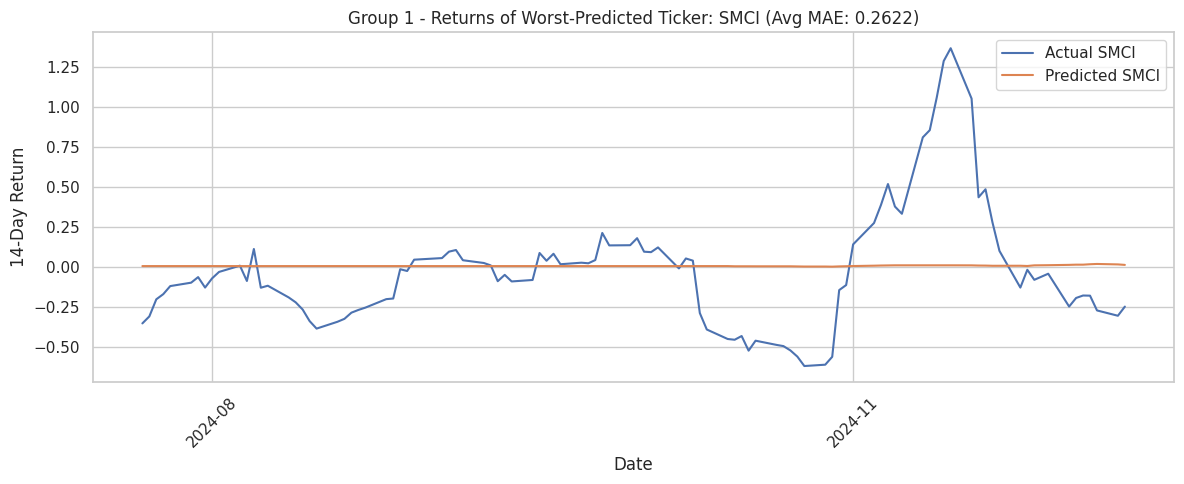

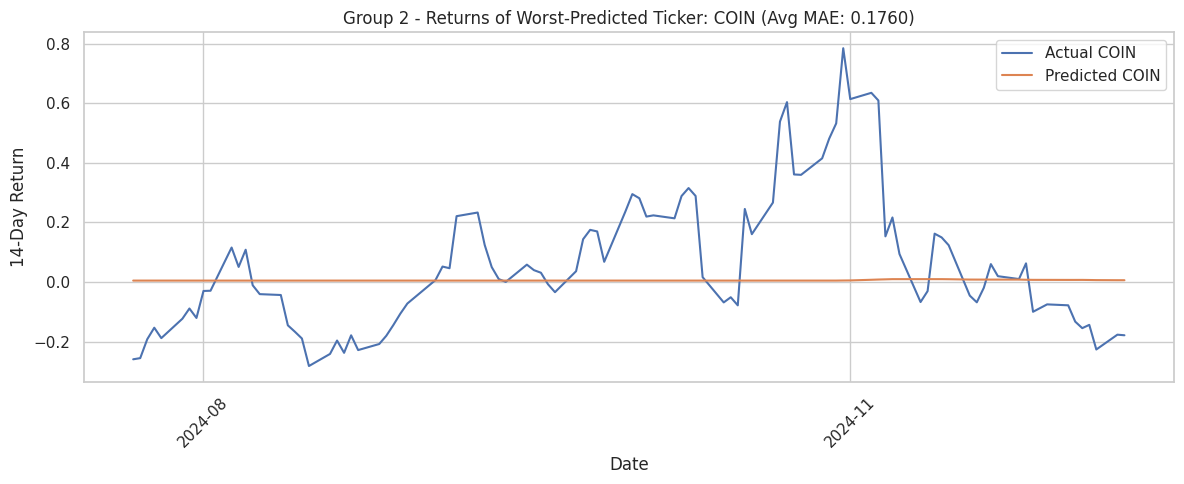

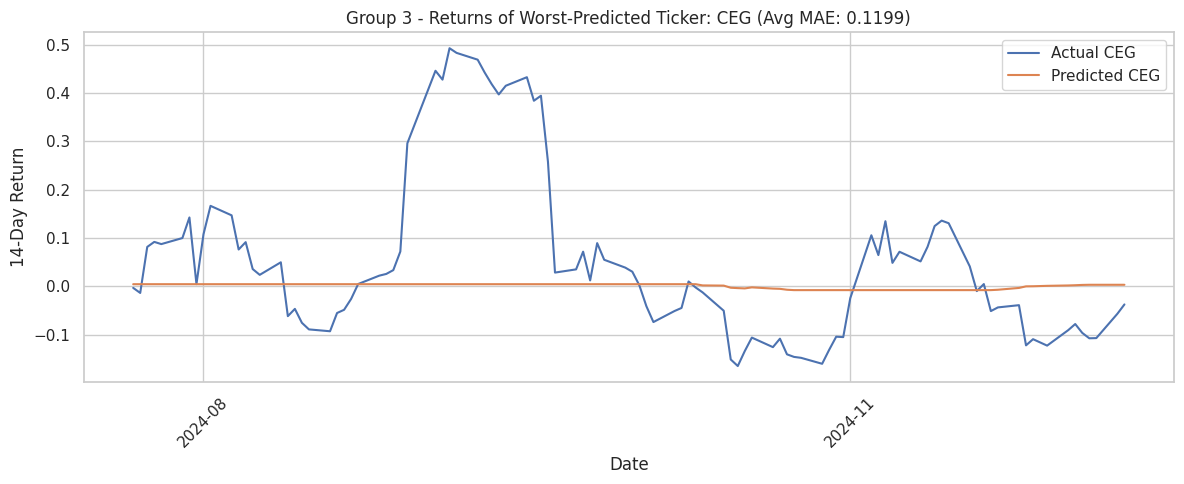

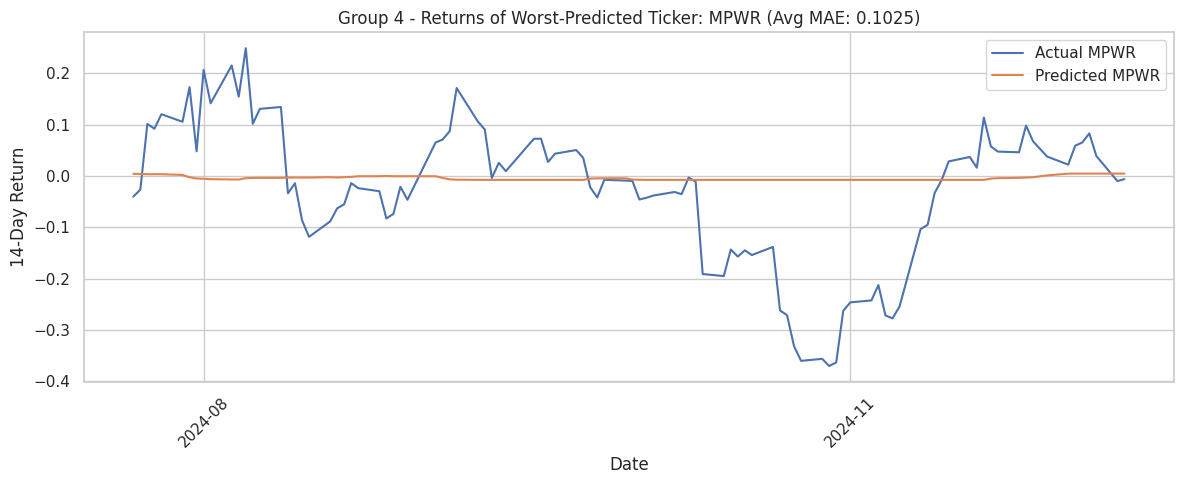

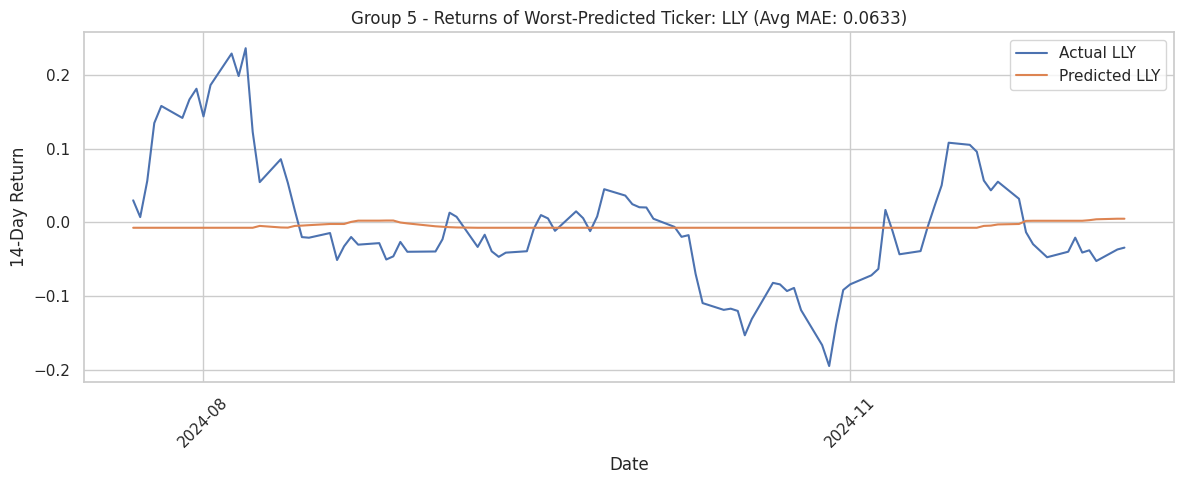

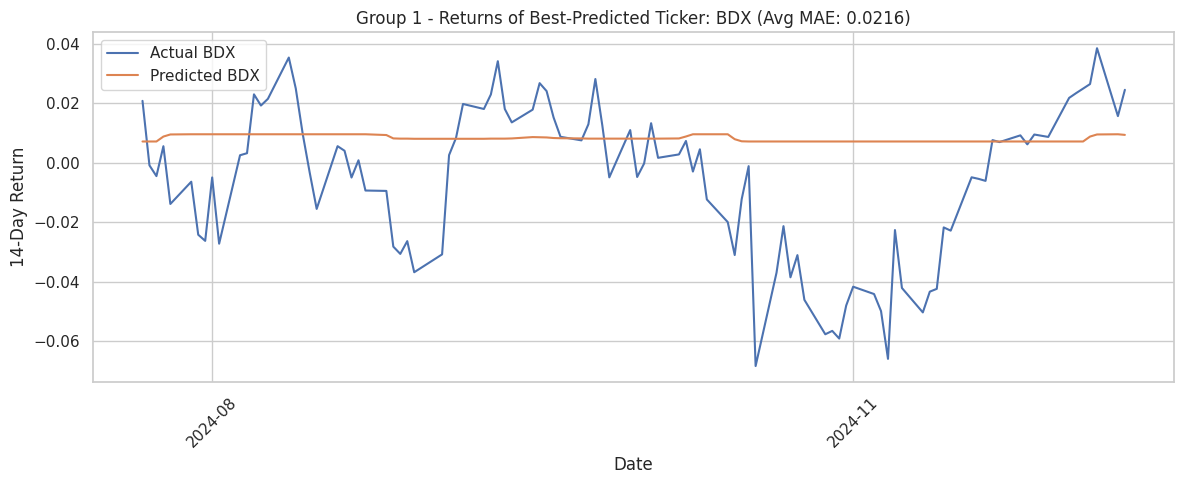

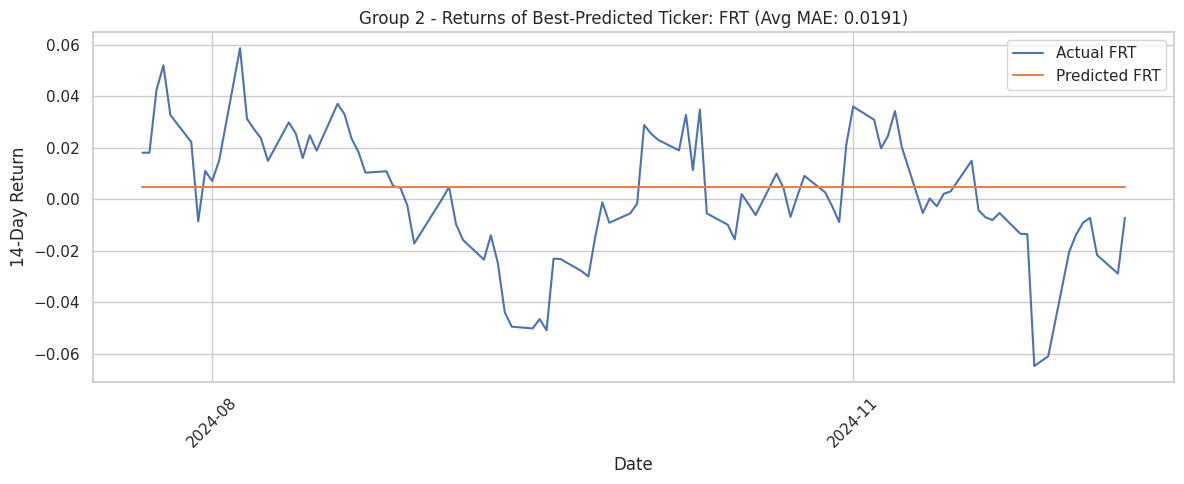

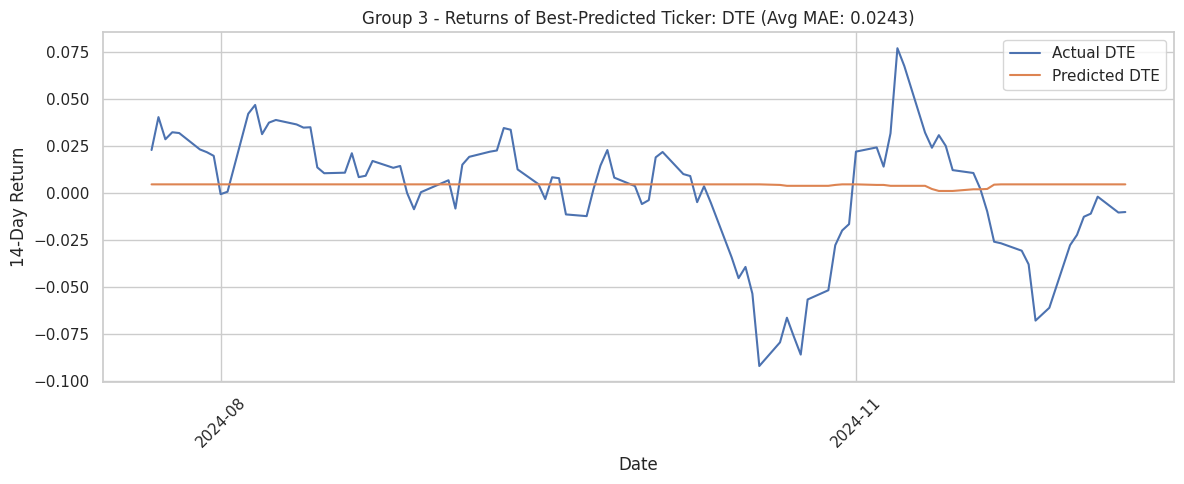

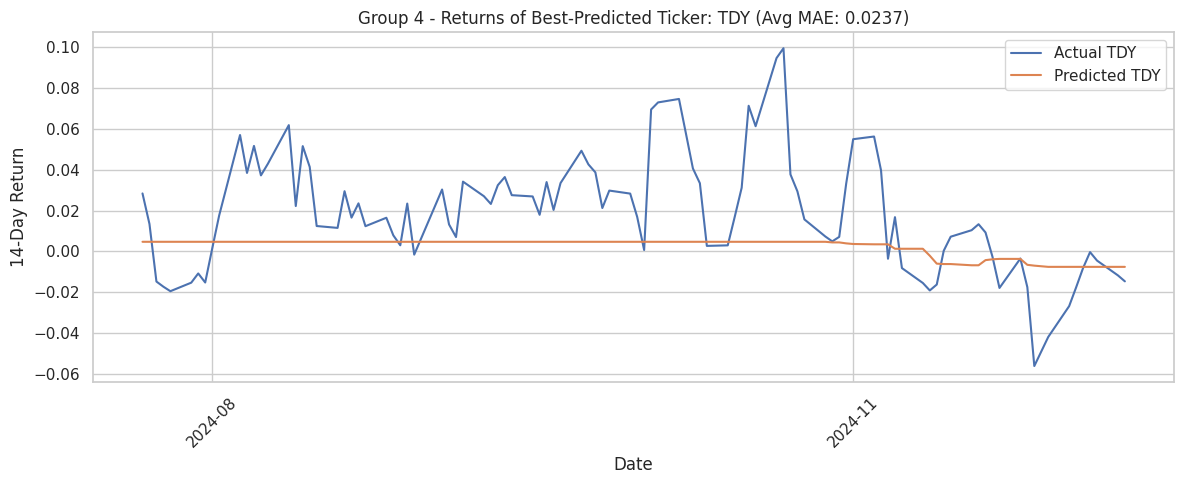

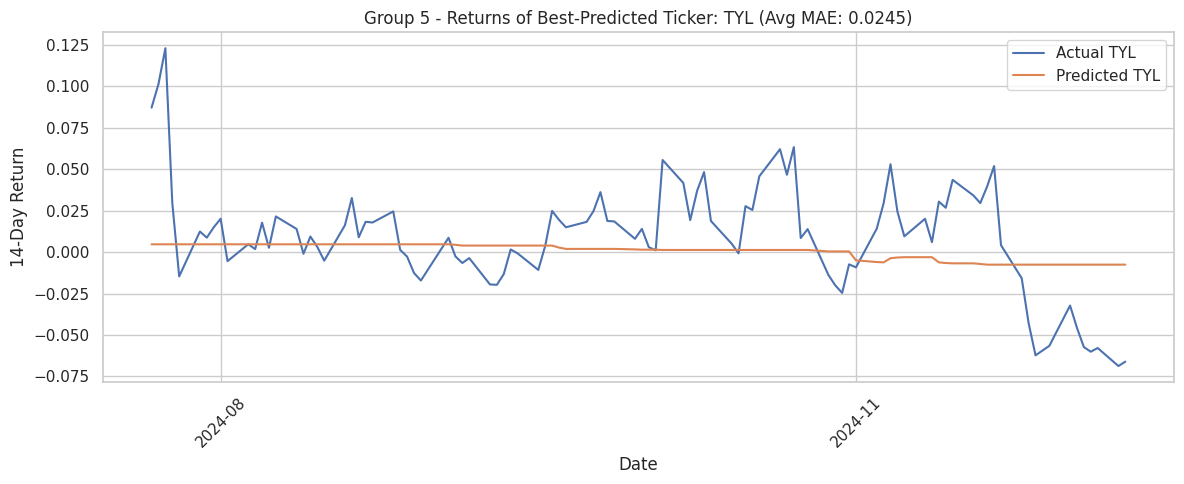

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assumes `eval_df` has columns: 'Ticker', 'Close', 'y_true', 'y_pred', 'Date', 'return_14d', 'AbsError'
assert {'Ticker', 'Close', 'y_true', 'y_pred', 'Date', 'return_14d', 'AbsError'}.issubset(eval_df.columns), "Missing required columns."

# 1. Calculate average price per ticker
avg_price_df = eval_df.groupby('Ticker')['Close'].mean().reset_index()
avg_price_df.rename(columns={'Close': 'AvgPrice'}, inplace=True)

# 2. Bin tickers into 5 groups of ~100 based on average price
num_groups = 5
if len(avg_price_df) < num_groups:
    print(f"Warning: Not enough tickers ({len(avg_price_df)}) to create {num_groups} price groups. Creating fewer groups.")
    num_groups = max(1, len(avg_price_df) // 20)  # Example: at least 20 tickers per group

if num_groups > 1 and len(np.unique(avg_price_df['AvgPrice'])) >= num_groups:
    avg_price_df = avg_price_df.sort_values('AvgPrice').reset_index(drop=True)
    # Use index for qcut to handle ties in AvgPrice
    avg_price_df['Group'] = pd.qcut(avg_price_df.index, q=num_groups, labels=False) + 1  # Groups 1 to num_groups
else:
    print("Warning: Not enough unique average prices to create distinct quantiles. Assigning all to group 1.")
    avg_price_df['Group'] = 1

# 3. Merge group info back into eval_df
eval_df = eval_df.drop(columns=['AvgPrice', 'Group'], errors='ignore')
eval_df = eval_df.merge(avg_price_df[['Ticker', 'AvgPrice', 'Group']], on='Ticker', how='left')

if eval_df['Group'].isnull().any():
    print("Warning: Some rows in eval_df did not get a group assignment after merge.")

# 4. Compute MAE per ticker, including group info
mae_per_ticker = eval_df.groupby(['Group', 'Ticker']).agg(
    AvgAbsError=('AbsError', 'mean'),
    AvgPrice=('AvgPrice', 'mean'),
    TrueMean=('y_true', 'mean'),
    PredMean=('y_pred', 'mean')
).reset_index()

mae_per_ticker = mae_per_ticker.dropna(subset=['AvgAbsError'])

# --- Define risk-adjusted return functions ---

def sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    if excess_returns.std() == 0:
        return np.nan
    return excess_returns.mean() / excess_returns.std()

# 5. Calculate risk-adjusted metrics per ticker on actual returns
risk_metrics_df = eval_df.groupby('Ticker').apply(
    lambda x: pd.Series({
        'Sharpe': sharpe_ratio(x['return_14d']),
    })
).reset_index()

# 6. Merge risk metrics into mae_per_ticker DataFrame
mae_per_ticker = mae_per_ticker.merge(risk_metrics_df, on='Ticker', how='left')

# 7. Show top 10 worst predictions per group and store for plotting
top_10_per_group = {}
num_top_worst = 10

for group_num in sorted(mae_per_ticker['Group'].unique()):
    print(f"\n--- Group {group_num} - Worst Predictions ---")
    group_mae_df = mae_per_ticker[mae_per_ticker['Group'] == group_num]

    top_n_worst = group_mae_df.sort_values('AvgAbsError', ascending=False).head(num_top_worst)
    top_10_per_group[group_num] = top_n_worst

    # Print key columns including risk metrics
    print(top_n_worst[['Ticker', 'AvgPrice', 'TrueMean', 'PredMean', 'AvgAbsError', 'Sharpe']])

# --- New: Show top 5 best predictions per group and store for plotting ---
top_5_best_per_group = {}
num_top_best = 5

for group_num in sorted(mae_per_ticker['Group'].unique()):
    print(f"\n--- Group {group_num} - Best Predictions ---")
    group_mae_df = mae_per_ticker[mae_per_ticker['Group'] == group_num]

    top_n_best = group_mae_df.sort_values('AvgAbsError', ascending=True).head(num_top_best)
    top_5_best_per_group[group_num] = top_n_best

    # Print key columns including risk metrics
    print(top_n_best[['Ticker', 'AvgPrice', 'TrueMean', 'PredMean', 'AvgAbsError', 'Sharpe']])

# 8. Plotting loop for the worst ticker per group
for group_num in sorted(top_10_per_group.keys()):
    if not top_10_per_group[group_num].empty:
        worst_ticker_symbol = top_10_per_group[group_num].iloc[0]['Ticker']

        group_df = eval_df[eval_df['Ticker'] == worst_ticker_symbol].copy()
        group_df['Date'] = pd.to_datetime(group_df['Date'])
        group_df = group_df.sort_values('Date')

        if not group_df.empty:
            plt.figure(figsize=(12, 5))
            sns.lineplot(data=group_df, x='Date', y='return_14d', label=f'Actual {worst_ticker_symbol}')
            sns.lineplot(data=group_df, x='Date', y='y_pred', label=f'Predicted {worst_ticker_symbol}')

            avg_mae_this_ticker = top_10_per_group[group_num].iloc[0]['AvgAbsError']

            ax = plt.gca()
            ax.set_title(f'Group {group_num} - Returns of Worst-Predicted Ticker: {worst_ticker_symbol} (Avg MAE: {avg_mae_this_ticker:.4f})')
            ax.set_ylabel("14-Day Return")
            ax.set_xlabel("Date")
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.tight_layout()
            plt.legend()
            plt.show()
        else:
            print(f"No data found for ticker {worst_ticker_symbol} (Group {group_num}) to plot.")
    else:
        print(f"No worst tickers found for Group {group_num}.")

# --- New: Plotting loop for the best ticker per group
for group_num in sorted(top_5_best_per_group.keys()):
    if not top_5_best_per_group[group_num].empty:
        best_ticker_symbol = top_5_best_per_group[group_num].iloc[0]['Ticker']

        group_df = eval_df[eval_df['Ticker'] == best_ticker_symbol].copy()
        group_df['Date'] = pd.to_datetime(group_df['Date'])
        group_df = group_df.sort_values('Date')

        if not group_df.empty:
            plt.figure(figsize=(12, 5))
            sns.lineplot(data=group_df, x='Date', y='return_14d', label=f'Actual {best_ticker_symbol}')
            sns.lineplot(data=group_df, x='Date', y='y_pred', label=f'Predicted {best_ticker_symbol}')

            avg_mae_this_ticker = top_5_best_per_group[group_num].iloc[0]['AvgAbsError']

            ax = plt.gca()
            ax.set_title(f'Group {group_num} - Returns of Best-Predicted Ticker: {best_ticker_symbol} (Avg MAE: {avg_mae_this_ticker:.4f})')
            ax.set_ylabel("14-Day Return")
            ax.set_xlabel("Date")
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.tight_layout()
            plt.legend()
            plt.show()
        else:
            print(f"No data found for ticker {best_ticker_symbol} (Group {group_num}) to plot.")
    else:
        print(f"No best tickers found for Group {group_num}.")
